In [5]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
# set path to project directory
root_dir = Path.cwd().parents[1]
if not root_dir in sys.path:
    sys.path.insert(0, str(root_dir))

from placefield_dynamics.placefield_detection.utils import load_data
from placefield_dynamics.placefield_detection.utils import (
    gauss_smooth,
)

from placefield_dynamics.orientation_detection.utils import elliptical_pdf, softplus


import numpy as np
from matplotlib import pyplot as plt

# from ipywidgets import interact

In [6]:
# Demonstration: Recover a (Gabor-like) receptive field from few grating phases
#
# Pipeline:
# 1) Generate a ground-truth Gabor RF g(x,y).
# 2) Stimulate with gratings at multiple orientations θ and spatial frequencies f,
#    but only a FEW phases φ (e.g., 3-4).
# 3) Fit, for each (θ,f), a cosine over phase: r(φ) = a cos φ + b sin φ + c.
#    Recover complex coefficients a,b  -> amplitude A = sqrt(a^2 + b^2) and preferred phase φ0 = atan2(b,a).
# 4) Reconstruct an RF by Fourier synthesis: g_rec(x,y) ≈ Σ_{θ,f} [a cos(2π f k·x) + b sin(2π f k·x)].
# 5) Fit a parametric Gabor to g_rec and compare to ground truth.

from scipy.optimize import least_squares

In [141]:
# -----------------------------
# Utilities
# -----------------------------


def gabor_2d(x, y, theta, f, sigma, gamma=0.6, phase=0.0):
    """
    2D Gabor: Gaussian envelope * cosine carrier.
    x,y: meshgrid coordinates in [-1,1].
    theta: orientation (radians) of the carrier.
    f: spatial frequency (cycles per 2 units of space since x,y in [-1,1]).
    sigma: std of Gaussian envelope (in same units as x,y).
    gamma: aspect ratio (y-axis scaling inside Gaussian).
    phase: carrier phase (radians).
    """
    ct, st = np.cos(theta), np.sin(theta)
    x_p = x * ct + y * st
    y_p = -x * st + y * ct
    gauss = np.exp(-(x_p**2 + (gamma**2) * y_p**2) / (2 * sigma**2))
    carrier = np.cos(2 * np.pi * f * x_p + phase)
    g = gauss * carrier
    g = g - g.mean()
    nrm = np.sqrt(np.sum(g**2) + 1e-12)
    return g / nrm


def grating(x, y, theta, f, phase):
    """Sinusoidal grating: cos(2π f (x cosθ + y sinθ) + phase)."""
    ct, st = np.cos(theta), np.sin(theta)
    x_p = x * ct + y * st
    return np.cos(2 * np.pi * f * x_p + phase)


def fit_ab_c(phis, responses):
    """
    Solve least squares for r(φ) = a cos φ + b sin φ + c,
    given K phase samples (K >= 3).
    Returns a, b, c.
    """
    C = np.column_stack([np.cos(phis), np.sin(phis), np.ones_like(phis)])
    w, *_ = np.linalg.lstsq(C, responses, rcond=None)
    a, b, c = w
    return a, b, c


def synthesize_rf_from_ab(x, y, thetas, freqs, a_map, b_map):
    """
    Fourier synthesis of RF using estimated cosine and sine coefficients:
    g_rec(x,y) = sum_{θ,f} [ a(θ,f) * cos(2π f k·x) + b(θ,f) * sin(2π f k·x) ]
    """
    X = np.zeros_like(x, dtype=float)
    for i, th in enumerate(thetas):
        ct, st = np.cos(th), np.sin(th)
        x_p = x * ct + y * st
        for j, f in enumerate(freqs):
            X += a_map[i, j] * np.cos(2 * np.pi * f * x_p) + b_map[i, j] * np.sin(
                2 * np.pi * f * x_p
            )
    X = X - X.mean()
    nrm = np.sqrt(np.sum(X**2) + 1e-12)
    return X / nrm


def fit_gabor_to_image(
    img,
    x,
    y,
    theta0,
    f0,
    sigma0,
    gamma0=0.6,
    phase0=0.0,
    lb=np.array([-np.pi / 2, 0.01, 0.05, 0.2, -np.pi, 0.0, 0.0]),
    ub=np.array([np.pi / 2, 4.0, 1.0, 3.0, np.pi, 5.0, 1.0]),
):
    """
    Fit a Gabor to an image by minimizing L2 error.
    Parameters to fit: theta, f, sigma, gamma, phase, amplitude, bias.
    """

    def model(params):
        theta, f, sigma, gamma, phase, amp, bias = params
        g = gabor_2d(x, y, theta, f, sigma, gamma=gamma, phase=phase)

        # softplus(
        #         rate * params["amplitude"], alpha=1.0, delta=bias
        #     )
        return amp * g + bias

    def residuals(params):
        return (model(params) - img).ravel()

    p0 = np.array([theta0, f0, sigma0, gamma0, phase0, 1.0, 0.0], dtype=float)
    print(f"Initial parameters: {p0}")

    print("Lower bounds:", lb)
    print("Upper bounds:", ub)

    res = least_squares(
        residuals, p0, bounds=(lb, ub), xtol=1e-9, ftol=1e-9, gtol=1e-9, max_nfev=2000
    )
    return res.x, res

Initial parameters: [0.26179939 1.92857143 0.4        0.8        0.         1.
 0.        ]
Lower bounds: [-1.57079633  0.01        0.05        0.2        -3.14159265  0.
  0.        ]
Upper bounds: [1.57079633 4.         1.         3.         3.14159265 5.
 1.        ]


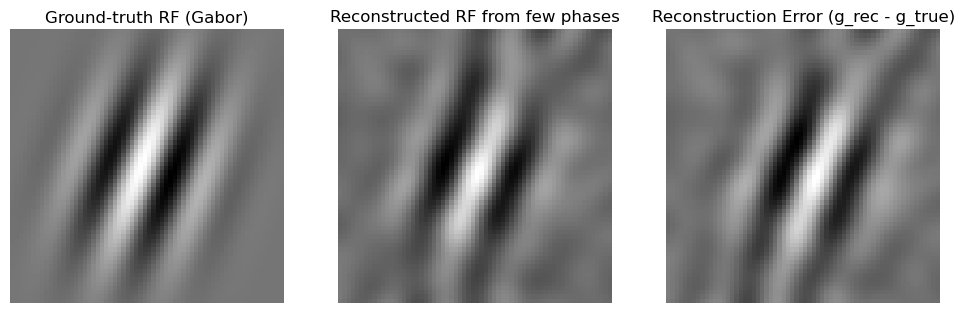

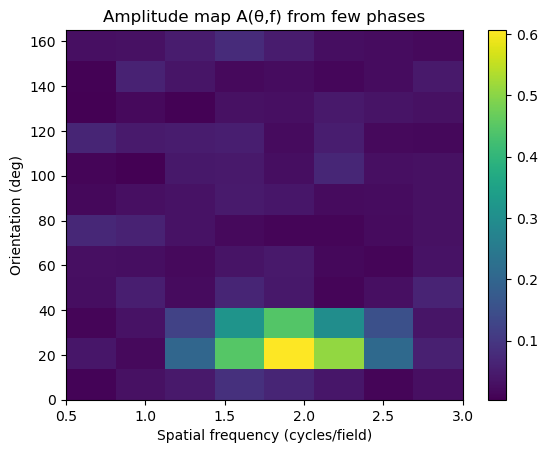

True parameters:
  theta(deg)=20.00, f=2.000, sigma=0.350, gamma=0.700, phase(deg)=30.00
Fitted (from reconstruction) parameters:
  theta(deg)=19.71, f=1.873, sigma=0.338, gamma=0.732, phase(deg)=-28.02
  amplitude=0.955, bias=0.000


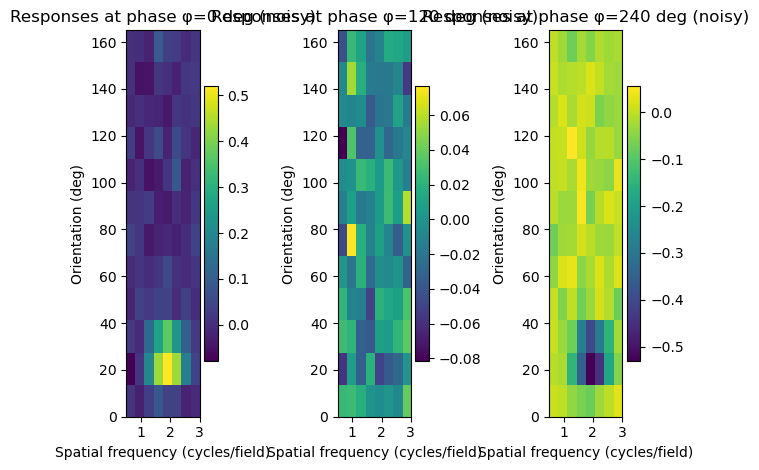

In [142]:
# 1) Ground-truth RF (Gabor)
N = 64
grid = np.linspace(-1, 1, N)
xx, yy = np.meshgrid(grid, grid)

true_theta = np.deg2rad(20.0)  # 20 degrees
true_f = 2.0  # cycles across [-1,1] extent
true_sigma = 0.35
true_gamma = 0.7
true_phase = np.deg2rad(30.0)

g_true = gabor_2d(xx, yy, true_theta, true_f, true_sigma, true_gamma, true_phase)

# 2) Stimulus set: orientations, frequencies, and FEW phases
thetas = np.deg2rad(np.linspace(0, 180, 12, endpoint=False))  # 12 orientations
freqs = np.linspace(0.5, 3.0, 8)  # 8 spatial frequencies
phis = np.deg2rad([0.0, 120.0, 240.0])  # ONLY 3 phases

# Generate responses r(θ, f, φ) = <g_true, grating(θ,f,φ)>
responses = np.zeros((len(thetas), len(freqs), len(phis)), dtype=float)
for i, th in enumerate(thetas):
    for j, f in enumerate(freqs):
        for k, ph in enumerate(phis):
            stim = grating(xx, yy, th, f, ph)
            stim = stim - stim.mean()
            stim /= np.sqrt(np.sum(stim**2) + 1e-12)
            responses[i, j, k] = np.sum(g_true * stim)

# Add mild noise to mimic experimental data
rng = np.random.default_rng(1)
noise_level = 0.03
responses_noisy = responses + noise_level * rng.standard_normal(responses.shape)

# 3) For each (θ,f), fit r(φ) = a cos φ + b sin φ + c
a_map = np.zeros((len(thetas), len(freqs)))
b_map = np.zeros((len(thetas), len(freqs)))
c_map = np.zeros((len(thetas), len(freqs)))
A_map = np.zeros((len(thetas), len(freqs)))  # amplitude
phi0_map = np.zeros((len(thetas), len(freqs)))  # preferred phase

for i in range(len(thetas)):
    for j in range(len(freqs)):
        a, b, c = fit_ab_c(phis, responses_noisy[i, j, :])
        a_map[i, j], b_map[i, j], c_map[i, j] = a, b, c
        A_map[i, j] = np.sqrt(a * a + b * b)
        phi0_map[i, j] = np.arctan2(b, a)

# 4) Reconstruct RF by Fourier synthesis from (a,b)
g_rec = synthesize_rf_from_ab(xx, yy, thetas, freqs, a_map, b_map)

# 5) Fit a parametric Gabor to the reconstructed RF
i_peak, j_peak = np.unravel_index(np.argmax(A_map), A_map.shape)
theta_guess = thetas[i_peak]
f_guess = freqs[j_peak]
sigma_guess = 0.4
gamma_guess = 0.8
phase_guess = 0.0

(params_fit, res_fit) = fit_gabor_to_image(
    g_rec, xx, yy, theta_guess, f_guess, sigma_guess, gamma_guess, phase_guess
)
theta_fit, f_fit, sigma_fit, gamma_fit, phase_fit, amp_fit, bias_fit = params_fit

# 6) Visualizations (each chart its own figure; no seaborn, no custom colors)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(g_true, cmap="gray", extent=[-1, 1, -1, 1])
axes[0].set_title("Ground-truth RF (Gabor)")
axes[0].axis("off")
# plt.show()

axes[1].imshow(g_rec, cmap="gray", extent=[-1, 1, -1, 1])
axes[1].set_title("Reconstructed RF from few phases")
axes[1].axis("off")

err = g_rec - g_true
# fig_err, ax_err = plt.subplots()
axes[2].imshow(err, cmap="gray", extent=[-1, 1, -1, 1])
axes[2].set_title("Reconstruction Error (g_rec - g_true)")
axes[2].axis("off")
plt.show()

plt.figure()
plt.imshow(
    A_map,
    aspect="auto",
    origin="lower",
    extent=[freqs[0], freqs[-1], np.rad2deg(thetas[0]), np.rad2deg(thetas[-1])],
)
plt.xlabel("Spatial frequency (cycles/field)")
plt.ylabel("Orientation (deg)")
plt.title("Amplitude map A(θ,f) from few phases")
plt.colorbar()
plt.show()

print("True parameters:")
print(
    f"  theta(deg)={np.rad2deg(true_theta):.2f}, f={true_f:.3f}, sigma={true_sigma:.3f}, gamma={true_gamma:.3f}, phase(deg)={np.rad2deg(true_phase):.2f}"
)
print("Fitted (from reconstruction) parameters:")
print(
    f"  theta(deg)={np.rad2deg(theta_fit):.2f}, f={f_fit:.3f}, sigma={sigma_fit:.3f}, gamma={gamma_fit:.3f}, phase(deg)={np.rad2deg(phase_fit):.2f}"
)
print(f"  amplitude={amp_fit:.3f}, bias={bias_fit:.3f}")


plt.figure()
for ph_idx, ph in enumerate(phis):
    plt.subplot(1, len(phis), ph_idx + 1)
    plt.imshow(
        responses_noisy[:, :, ph_idx],
        aspect="auto",
        origin="lower",
        extent=[freqs[0], freqs[-1], np.rad2deg(thetas[0]), np.rad2deg(thetas[-1])],
    )
    plt.xlabel("Spatial frequency (cycles/field)")
    plt.ylabel("Orientation (deg)")
    plt.title(f"Responses at phase φ={np.rad2deg(ph):.0f} deg (noisy)")
    plt.colorbar()
plt.tight_layout()
plt.show()

In [143]:
from placefield_dynamics.orientation_detection.utils.utils_analysis import (
    calculate_firing_maps,
    get_spikes,
    get_unique_stimulus_values,
)

folderPath = Path("../../../data/Subhodeep/ID20/20230913/")
stimulusPath = folderPath / "ID20_1_230913.1_ipsi_stimProtocol_191.mat"
# stimulusPath = folderPath / "ID20_1_230913.1_bino_stimProtocol_1820.mat"
# stimulusPath = folderPath / "ID20_1_230913.1_cont_stimProtocol_1840.mat"
caimanPath = folderPath / "results_CaImAn_20230913_20_00003_align_redetected.mat"

ld = load_data(stimulusPath)
stimulus_data = ld["runInfo"]

meta_data = load_data(folderPath / "CaimanMeta.mat")
f = meta_data["CaimanMeta"]["frame_rate"]

caiman_data = load_data(caimanPath)
stimulus_data["frame_times"] = np.arange(caiman_data["C"].shape[1]) / f

spikes = get_spikes(caiman_data["S"], f=f)
event_counts, dwelltime = calculate_firing_maps(
    stimulus_data=stimulus_data, spikes=spikes, dt_onset=0.25, dt_response=0.25
)

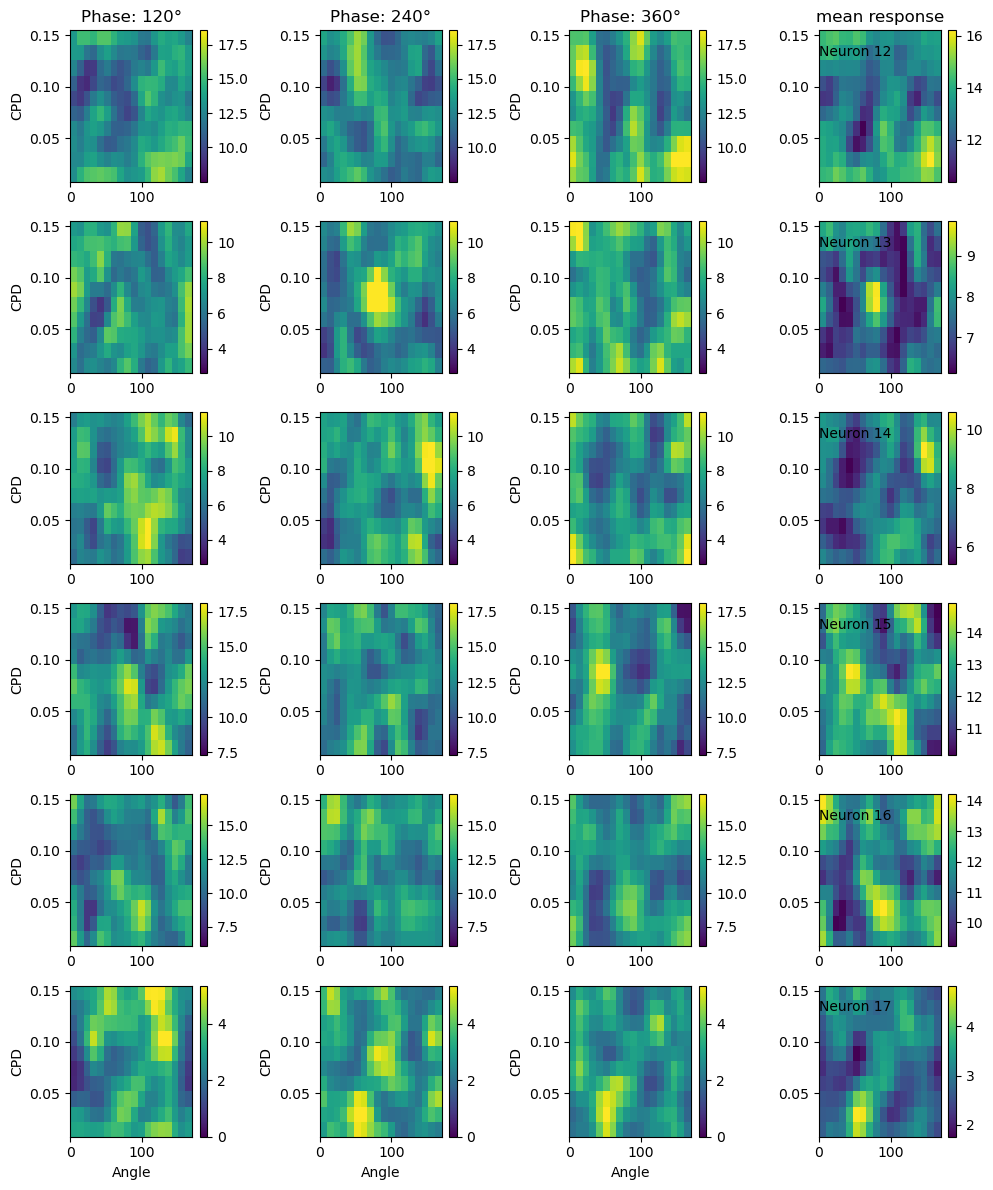

In [144]:
from placefield_dynamics.orientation_detection.utils.utils_display import (
    plot_firing_maps,
)

neurons = range(12, 18)
unique_values = get_unique_stimulus_values(stimulus_data)
plot_firing_maps(
    firing_maps=event_counts / dwelltime[..., np.newaxis],
    neurons=neurons,
    unique_values=unique_values,
)

In [145]:
unique_values["cycles"]

array([0.0079    , 0.01099588, 0.01530497, 0.02130273, 0.0296509 ,
       0.04127058, 0.05744382, 0.07995507, 0.1112881 , 0.1549    ])

(3, 18, 10)
(18, 10, 3)
{'phases': array([120, 240, 360], dtype=uint16), 'angles': array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170], dtype=uint8), 'cycles': array([0.0079    , 0.01099588, 0.01530497, 0.02130273, 0.0296509 ,
       0.04127058, 0.05744382, 0.07995507, 0.1112881 , 0.1549    ])}
Initial parameters: [0.17456055 0.1549     0.4        0.8        0.         1.
 0.        ]
Lower bounds: [-1.57079633  0.01        0.05        0.5        -3.14159265  0.
  0.        ]
Upper bounds: [ 1.57079633  0.2        10.          2.          3.14159265  5.
  1.        ]
Fitted (from reconstruction) parameters: [-8.12140240e-01  1.00000000e-02  1.00000000e+01  1.32860270e+00
 -2.62742902e-01  9.96742848e-01  8.46600271e-12]


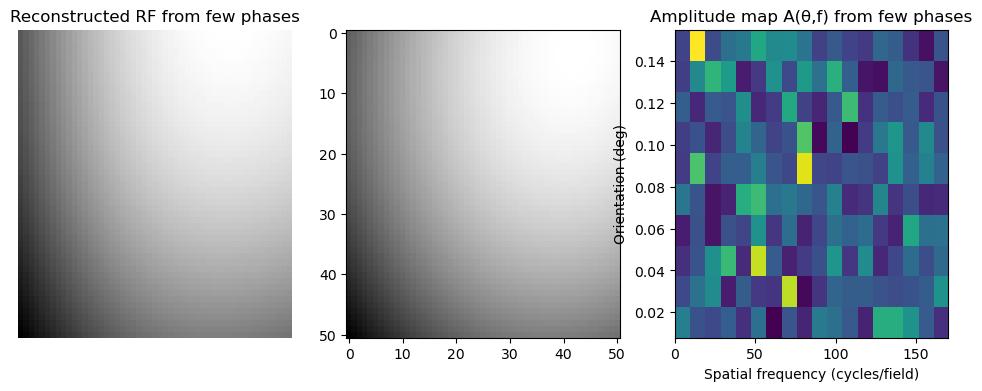

Fitted (from reconstruction) parameters:
  theta(deg)=-46.53, f=0.010, sigma=10.000, gamma=1.329, phase(deg)=-15.05
  amplitude=0.997, bias=0.000


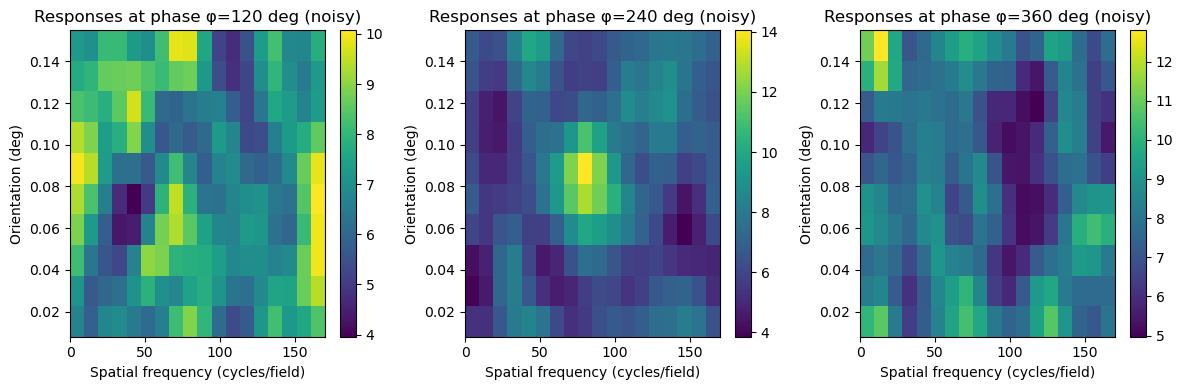

In [ ]:
n = 13
fmap = event_counts[..., n] / dwelltime
print(fmap.shape)
fmap = fmap.transpose(1, 2, 0)
print(fmap.shape)

N = 51
x_grid = np.linspace(-140 / 2, 140 / 2, N)
y_grid = np.linspace(-114 / 2, 114 / 2, N)
xx, yy = np.meshgrid(x_grid, y_grid)

xx = np.deg2rad(xx)
yy = np.deg2rad(yy)

print(unique_values)
thetas = np.deg2rad(unique_values["angles"])
freqs = unique_values["cycles"] * 180 / np.pi
phis = np.deg2rad(unique_values["phases"])

# 3) For each (θ,f), fit r(φ) = a cos φ + b sin φ + c
a_map = np.zeros((len(thetas), len(freqs)))
b_map = np.zeros((len(thetas), len(freqs)))
c_map = np.zeros((len(thetas), len(freqs)))
A_map = np.zeros((len(thetas), len(freqs)))  # amplitude
phi0_map = np.zeros((len(thetas), len(freqs)))  # preferred phase

for i in range(len(thetas)):
    for j in range(len(freqs)):
        a, b, c = fit_ab_c(phis, fmap[i, j, :])
        a_map[i, j], b_map[i, j], c_map[i, j] = a, b, c
        A_map[i, j] = np.sqrt(a * a + b * b)
        phi0_map[i, j] = np.arctan2(b, a)

# 4) Reconstruct RF by Fourier synthesis from (a,b)
g_rec = synthesize_rf_from_ab(xx, yy, thetas, freqs, a_map, b_map)

# 5) Fit a parametric Gabor to the reconstructed RF
i_peak, j_peak = np.unravel_index(np.argmax(A_map), A_map.shape)
theta_guess = thetas[i_peak]
f_guess = freqs[j_peak]
sigma_guess = 0.4
gamma_guess = 0.8
phase_guess = 0.0

(params_fit, res_fit) = fit_gabor_to_image(
    g_rec,
    xx,
    yy,
    theta_guess,
    f_guess,
    sigma_guess,
    gamma_guess,
    phase_guess,
    lb=np.array([-np.pi / 2, 0.01, 0.05, 0.5, -np.pi, 0, 0]),
    ub=np.array([np.pi / 2, 0.2, 10, 2, np.pi, 5, 1]),
)
theta_fit, f_fit, sigma_fit, gamma_fit, phase_fit, amp_fit, bias_fit = params_fit
print("Fitted (from reconstruction) parameters:", params_fit)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(g_rec, cmap="gray", aspect="auto")  # , extent=[-1, 1, -1, 1])
axes[0].set_title("Reconstructed RF from few phases")
axes[0].axis("off")

theta_fit, f_fit, sigma_fit, gamma_fit, phase_fit, amp_fit, bias_fit = params_fit
g = gabor_2d(xx, yy, theta_fit, f_fit, sigma_fit, gamma_fit, phase_fit)
axes[1].imshow(g, cmap="gray", aspect="auto")

# plt.show()

# plt.figure()
axes[2].imshow(
    A_map.T,
    aspect="auto",
    origin="lower",
    extent=[np.rad2deg(thetas[0]), np.rad2deg(thetas[-1]), freqs[0], freqs[-1]],
)
axes[2].set_xlabel("Spatial frequency (cycles/field)")
axes[2].set_ylabel("Orientation (deg)")
axes[2].set_title("Amplitude map A(θ,f) from few phases")
plt.show()

print("Fitted (from reconstruction) parameters:")
print(
    f"  theta(deg)={np.rad2deg(theta_fit):.2f}, f={f_fit:.3f}, sigma={sigma_fit:.3f}, gamma={gamma_fit:.3f}, phase(deg)={np.rad2deg(phase_fit):.2f}"
)
print(f"  amplitude={amp_fit:.3f}, bias={bias_fit:.3f}")

sigma = (1.0, 1.0)
plt.figure(figsize=(12, 4))
for ph_idx, ph in enumerate(phis):
    plt.subplot(1, len(phis), ph_idx + 1)
    plt.imshow(
        gauss_smooth(fmap[:, :, ph_idx], sigma).T,
        aspect="auto",
        origin="lower",
        extent=[
            np.rad2deg(thetas[0]),
            np.rad2deg(thetas[-1]),
            freqs[0],
            freqs[-1],
        ],
    )
    plt.xlabel("Spatial frequency (cycles/field)")
    plt.ylabel("Orientation (deg)")
    plt.title(f"Responses at phase φ={np.rad2deg(ph):.0f} deg (noisy)")
    plt.colorbar()
plt.tight_layout()
plt.show()

In [155]:
xx

array([[-1.22173048, -1.17286126, -1.12399204, ...,  1.12399204,
         1.17286126,  1.22173048],
       [-1.22173048, -1.17286126, -1.12399204, ...,  1.12399204,
         1.17286126,  1.22173048],
       [-1.22173048, -1.17286126, -1.12399204, ...,  1.12399204,
         1.17286126,  1.22173048],
       ...,
       [-1.22173048, -1.17286126, -1.12399204, ...,  1.12399204,
         1.17286126,  1.22173048],
       [-1.22173048, -1.17286126, -1.12399204, ...,  1.12399204,
         1.17286126,  1.22173048],
       [-1.22173048, -1.17286126, -1.12399204, ...,  1.12399204,
         1.17286126,  1.22173048]], shape=(51, 51))